Importing required libraries

In [ ]:
#Importing required libraries
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model




Setting numpy, python, tensorflow seeds to get consistent result

In [ ]:

seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)


Visualize the data with its labels

In [ ]:
#creating a matplotlib figure
plt.figure(figsize = (30, 30))
#Get Names of all classes in DATASET
class_names=os.listdir('DATASET')
# Generate a random sample of images each time the cell runs
random_range = random.sample(range(len(class_names)),5)


<Figure size 2160x2160 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


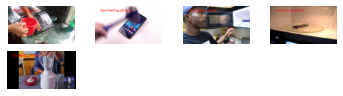

In [ ]:
## Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):
  # Getting Class Name using Random Index
  selected_class_Name = class_names[random_index]
  #Getting a list of all the video files present in a Class Directory
  video_files_names_list = os.listdir(f'DATASET/{selected_class_Name}')
  # Randomly selecting a video file
  selected_video_file_name = random.choice(video_files_names_list)
  # Reading the Video File Using the Video Capture
  video_reader = cv2.VideoCapture(f'DATASET/{selected_class_Name}/{selected_video_file_name}')
  # Reading The First Frame of the Video File
  _, bgr_frame = video_reader.read()
  # Closing the VideoCapture object and releasing all resources
  video_reader.release()
  # Converting the BGR Frame to RGB Frame
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  # Adding The Class Name Text on top of the Video Frame
  cv2.putText(rgb_frame, selected_class_Name, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
  # Assigning the Frame to a specific position of a subplot
  plt.subplot(5, 4, counter)
  plt.imshow(rgb_frame)
  plt.axis('off')
  plt.subplot(5, 4, counter)
  plt.imshow(rgb_frame)
  plt.axis('off')









Read and Pre-process the dataset

In [ ]:
#resizing all frames of the video to a common size
image_height, image_width = 112, 112
#setting maximum number of training images allowed for each class
max_images_per_class = 300
# selecting path of the directory containing the extracted dataset
dataset_directory = "DATASET"
#selecting all the class names for training
classes_list = class_names
#setting model output size to the length of classes_list used for training
model_output_size = len(classes_list)


Extract , Resize and Normalize frames

In [ ]:
#creating a function to extract frames from each video while performing other preprocessing operation like resizing and normalizing image
def frames_extraction(video_path):
  #Empty List declared to store video frames
  frames_list = []
  #Reading the Video File Using the VideoCapture
  video_reader = cv2.VideoCapture(video_path)
  # Iterating through Video Frames
  while True:
      # Reading a frame from the video file
      success, frame = video_reader.read()
      #If Video frame was not successfully read then break the loop
      if not success:
        break
      # Resize the Frame to fixed Dimensions
      resized_frame = cv2.resize(frame, (image_height, image_width))
      #Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
      normalized_frame = resized_frame / 255
      # Appending the normalized frame into the frames list
      frames_list.append(normalized_frame)
  #Closing the VideoCapture object and releasing all resources
  video_reader.release()
  #returning the frames list
  return frames_list



Dataset Creation

In [ ]:
#Creating function for final preprocessed dataset using the above frames_extraction function 
def create_dataset():
  # Declaring Empty Lists to store the features and labels values
    temp_features = []
    features = []
    labels = []
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))
        # Iterating through all the files present in the files list
        for file_name in files_list:
          # Construct the complete video path
          video_file_path = os.path.join(dataset_directory, class_name, file_name)
          # Calling the frame_extraction method for every video file path
          frames = frames_extraction(video_file_path)
          # Appending the frames to a temporary list
          temp_features.extend(frames)
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))
        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        # Emptying the temp_features list so it can be reused to store all frames of the next class
        temp_features.clear()
    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels) 
    return features, labels


In [ ]:
#Calling the create_dataset method which returns features and labels
features, labels = create_dataset()


Extracting Data of Class: hammering_phone
Extracting Data of Class: microwave_phone
Extracting Data of Class: Washing_laptop
Extracting Data of Class: microwave_shoes
Extracting Data of Class: Blending_phone


In [ ]:
#converting class labels to one hot encoded vectors
one_hot_encoded_labels = to_categorical(labels)


Split dataset into train and test sets

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

Construct the model

In [ ]:
#creating a function that will construct our model
def create_model():
    #using a Sequential model for model construction
    model = Sequential()
    # Defining The Model Architecture
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()
    return model
    
# Calling the create_model method
model = create_model()
print("model created")
 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 108, 108, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

Checking model's structure

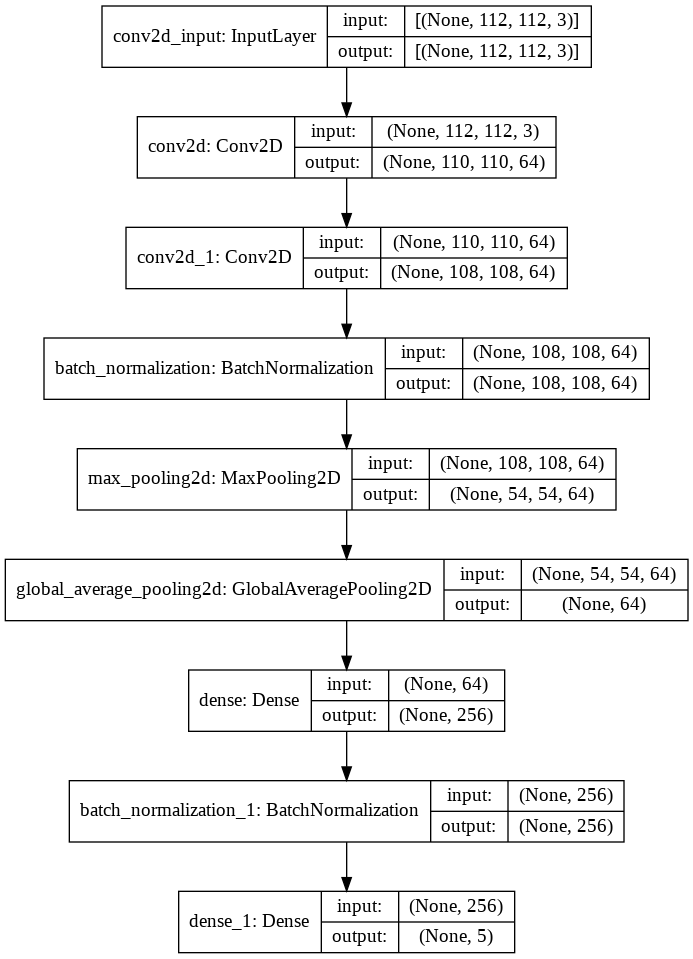

In [ ]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

Compile and train the model

In [ ]:
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
# Adding loss, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 25, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/25
240/240 [==============================] - 89s 363ms/step - loss: 1.2579 - accuracy: 0.4771 - val_loss: 1.6009 - val_accuracy: 0.2500
Epoch 2/25
240/240 [==============================] - 87s 363ms/step - loss: 1.1131 - accuracy: 0.5458 - val_loss: 1.3750 - val_accuracy: 0.5875
Epoch 3/25
240/240 [==============================] - 87s 363ms/step - loss: 1.0542 - accuracy: 0.6115 - val_loss: 6.4742 - val_accuracy: 0.2458
Epoch 4/25
240/240 [==============================] - 87s 363ms/step - loss: 1.0148 - accuracy: 0.5990 - val_loss: 1.5438 - val_accuracy: 0.4167
Epoch 5/25
240/240 [==============================] - 87s 363ms/step - loss: 0.9838 - accuracy: 0.6250 - val_loss: 0.7701 - val_accuracy: 0.7125
Epoch 6/25
240/240 [==============================] - 87s 363ms/step - loss: 0.8999 - accuracy: 0.6594 - val_loss: 1.4916 - val_accuracy: 0.5500
Epoch 7/25
240/240 [==============================] - 89s 370ms/step - loss: 0.8122 - accuracy: 0.7073 - val_loss: 4.6140 - val_ac

Evaluating the trained model

In [ ]:

model_evaluation_history = model.evaluate(features_test, labels_test)

10/10 [==============================] - 6s 580ms/step - loss: 0.1749 - accuracy: 0.9467


Save the model

In [ ]:
#Creating a useful name for our model
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
model_name = f'Model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Saving the Model
model.save(model_name)


Plot model's loss and accuracy curves

In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]
  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  # Adding title to the plot
  plt.title(str(plot_name))
  # Adding legend to the plot
  plt.legend()


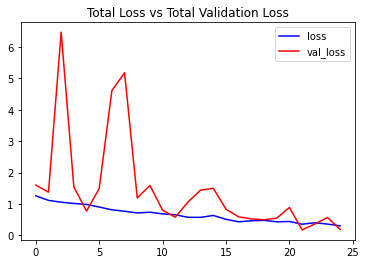

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

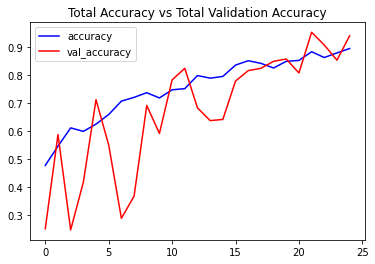

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Making prediction with the model

In [ ]:
pip install youtube_dl

     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [ ]:
pip install pafy

In [ ]:
#importing require library
import youtube_dl
import pafy
from moviepy.editor import *


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2318336/45929032 bytes (5.0%)5398528/45929032 bytes (11.8%)8437760/45929032 bytes (18.4%)11337728/45929032 bytes (24.7%)14385152/45929032 bytes (31.3%)17448960/45929032 bytes (38.0%)20545536/45929032 bytes (44.7%)23633920/45929032 bytes (51.5%)26697728/45929032 bytes (58.1%)29876224/45929032 bytes (65.0%)32997376/45929032 bytes (71.8%)36159488/45929032 bytes (78.7%)

In [ ]:
#creating a function to download you tube videos
def download_youtube_videos(youtube_video_url,output_directory):
  # Creating a Video object which includes useful information regarding the youtube video
  video = pafy.new(youtube_video_url)
  # Getting the best available quality object for the youtube video
  video_best = video.getbest()
  # Constructing the Output File Path
  output_file_path = f'{output_directory}/{video.title}.mp4'
  # Downloading the youtube video at the best available quality
  video_best.download(filepath = output_file_path, quiet = True)
  # Returning Video Title
  return video.title






In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):
  # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
  predicted_labels_probabilities_deque = deque(maxlen = window_size)
    # Reading the Video File using the VideoCapture Object
  video_reader = cv2.VideoCapture(video_file_path)
    # Getting the width and height of the video
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    # Writing the Overlayed Video Files Using the VideoWriter Object
  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))
  while (True):
    status, frame = video_reader.read()
    if not status:
      break
        # Resize the Frame to fixed Dimensions
    resized_frame = cv2.resize(frame, (image_height, image_width))
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255
        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
    predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]
        # Appending predicted label probabilities to the deque object
    predicted_labels_probabilities_deque.append(predicted_labels_probabilities)
        # Assuring that the Deque is completely filled before starting the averaging process
    if len(predicted_labels_probabilities_deque) == window_size:
        # Converting Predicted Labels Probabilities Deque into Numpy array
      predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)
            # Calculating Average of Predicted Labels Probabilities Column Wise
      predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)
            # Converting the predicted probabilities into labels by returning the index of the maximum value.
      predicted_label = np.argmax(predicted_labels_probabilities_averaged)
            # Accessing The Class Name using predicted label
      predicted_class_name = classes_list[predicted_label]
            # Overlaying Class Name Text Ontop of the Frame
      cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        # Writing The Frame
      video_writer.write(frame)
        # cv2.imshow('Predicted Frames', frame)
        # key_pressed = cv2.waitKey(10)
        # if key_pressed == ord('q'):
        #     break  # cv2.destroyAllWindows()
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them
    video_reader.release()
    video_writer.release()


Downloading a test video

In [ ]:
# Creating The Output directories if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok = True)
# Downloading a YouTube Video
video_title = download_youtube_videos('https://www.youtube.com/watch?v=3wNA-R8bFzk', output_directory)
# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'


Prediction:

In [ ]:

# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1
# Constructing The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'
# Calling the predict_on_live_video method to start the Prediction
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)
# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)



100%|██████████| 1/1 [00:00<00:00, 186.04it/s]
